### Linear Regression Bonus Challenge

To work through various questions, we'll first load in data and fit a model.

In [66]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('../data/housing.csv')

# create target variables
X = df.iloc[:, :-1]
X = (X - X.mean()) / X.std()
y = df['PRICE']

# fit model
lreg = LinearRegression()
lreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**Question 1).** Standardizing your data changes your coefficients, but not your final results.  Can you explain this effect graphically?  (**Hint:** Histograms help a lot).

Essentially, standardizing changes the scale of your data, but none of its other internal properties.  

Looking at a histogram of standardized and non-standardized columns usually makes this pretty clear, as you can see they're exactly the same, save for the scale.

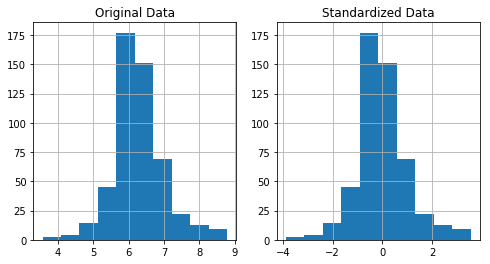

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

df['RM'].hist(ax=ax[0]).set_title('Original Data')
X['RM'].hist(ax=ax[1]).set_title('Standardized Data');

You could also look at other aspects of their distribution and see that they're the same.

In [31]:
# have the same level of skew -- a measure of how 'left' or 'right' shifted your distribution is
df['RM'].skew(), X['RM'].skew()

(0.4036121332887437, 0.4036121332887442)

In [32]:
# ditto for kurtosis
df['RM'].kurt(), X['RM'].kurt()

(1.8915003664993395, 1.8915003664993395)

**Question 2).** With standardized data, each column has an average value of 0 and a standard deviation of 1.  This means if the value of a column is its average, it will have no additional effect on the price of a house, and the observed coefficient value comes from increasing/decreasing the column value 1 standard deviation from where it's at.  

With that being said......

**What is the impact of adding one additional room to a house's selling price?**  (**Note:**  This is NOT asking what happens if you increase the number of rooms by one standard deviation.  Just ONE room).

In [21]:
# look at coefficients
coeffs = pd.DataFrame({
    'Variable': X.columns,
    'Weight': lreg.coef_ 
}).sort_values(by='Weight', ascending=False)
coeffs

,Variable,Weight
5,RM,2.676877
8,RAD,2.664852
1,ZN,1.082639
11,B,0.850109
3,CHAS,0.682414
2,INDUS,0.141039
6,AGE,0.019485
0,CRIM,-0.929065
4,NOX,-2.058754
10,PTRATIO,-2.062646


In [8]:
# we can see that a 1 standard deviation increase in the number of rooms comes out to 0.7 units
df['RM'].std()

0.7026171434153234

In [9]:
# Adding an additional room is a 1.423 standard deviation increase
1 / df['RM'].std()

1.4232502143900734

In [10]:
# store the variable for the standard deviation increase in the RM column
std_devs = 1 / df['RM'].std()

# multiply the standard deviation increase by the coefficient
std_devs * coeffs.loc[5, 'Weight']

3.8098652068092185

According to our model, we would expect the price of a house to increase by 3.8 with each additional room.

**Question 3).** If a house has 3 rooms in it, what would be the expected change in the house's selling price as a result, all else being equal?

If converting back and forth from standardized to non-standardized data, you basically need to convert values back and forth between their standard deviations.  

Since a house with the 'average' number of rooms will have 0 impact, and its coefficient is the impact of a unit increase in the number of standard deviations away from the mean you are, we need to figure out how many standard deviations 3 is away from the average number of rooms per house.

In [13]:
# average number of rooms
df['RM'].mean()

6.284634387351788

In [14]:
# difference
3 - df['RM'].mean()

-3.2846343873517876

In [16]:
# change in number of standard deviations * coefficients

std_devs = (3 - df['RM'].mean())/df['RM'].std()
std_devs*coeffs.loc[5, 'Weight']

-12.514014269460688

Thus, we would expect a house with 3 rooms to have a decrease in selling price of 12.51 units compared to what it would otherwise, since this is 4.67 standard deviations below normal.

### Regression Deep Dive With Statsmodels

**Question 4).**  Use `statsmodels` to run a regression model on your dataset, and observe your results.  Then, find out.....**what variables are good candidates to be removed from your dataset?**

Don't forget to use the `add_constant` method to get valid results.

In [18]:
import statsmodels.api as sm
from statsmodels.tools import add_constant

X_std = add_constant(X)

# this is the equivalent of doing lreg = LinearRegression() that we did previously
# notice that you put y before X
mod = sm.OLS(y, X_std)

# because we loaded in y and X previously, no need to use them here
results = mod.fit()

# the results() object provides a lot of data, most importantly the summary(), which we can see here
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          6.72e-135
Time:                        09:16:48   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.211    106.814      0.0

Going by the above results, we would remove `INDUS` and `AGE` from our model, since their confidence intervals pass over 0.  Note this is the same thing as having a p-value that is greater than 0.05.

**Question 5).** Re-run your regression model without the `add_constant` function, and observe the changes in your results.  Any idea what it's doing?

In [19]:
mod = sm.OLS(y, X)

# because we loaded in y and X previously, no need to use them here
results = mod.fit()

# the results() object provides a lot of data, most importantly the summary(), which we can see here
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.477
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           3.14e-07
Time:                        09:18:37   Log-Likelihood:                -2304.8
No. Observations:                 506   AIC:                             4636.
Df Residuals:                     493   BIC:                             4691.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.9291      1.389     -0.669      0.5

If you don't add the constant term (which is a column of 1's in your dataset), there's nothing representing the intercept, which is why your R-squared values are so low.  

Basically, the predictions are so bad that there's no way to reliably get a feel for the true impact of a particular variable, which is why the confidence intervals are all over the place.  Most stats libraries do this for you automatically when you call `fit()`, but statsmodels is a little special this way.

Looking at these results, the only variable you could safely say has an impact would be `LSTAT`.

### Extending Scikit Learn

**Question 6a):** Create a training and test set from the housing data.  Use the `StandardScaler` to transform your training data, and then do the same on the test set, using the stored values from the `fit_transform()` method.

In [34]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# initialize
sc = StandardScaler()

# create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

# use fit_transform() and transform()
X_train_std = sc.fit_transform(X_train)
X_test_std  = sc.transform(X_test)

And if you look you'll see their new averages and standard deviations are similar, but not quite the same, reflecting the differences in values between the two datasets.

In [36]:
# training set means and standard deviations
X_train_std.mean(0), X_train_std.std(0)

(array([-3.07784601e-17, -3.73738444e-17, -2.41830758e-17,  1.03327687e-16,
         2.19846143e-17,  1.09923072e-17,  8.79384574e-18, -1.53892300e-17,
        -5.05646130e-17, -3.51753830e-17, -2.85799987e-17,  2.19846143e-18,
        -2.85799987e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [37]:
# test set means and standard deviations -- close but a little different
X_test_std.mean(0), X_test_std.std(0)

(array([ 0.04983634, -0.0162893 ,  0.03619723,  0.09731109,  0.06872904,
        -0.07365204,  0.08781827,  0.00197489,  0.13002958,  0.09965871,
         0.10170859, -0.12304398,  0.08559268]),
 array([1.09481879, 1.05039433, 0.96103668, 1.15587627, 1.03578002,
        1.09818222, 1.04487881, 0.92074662, 1.05503883, 1.02393229,
        0.90477595, 1.11668606, 1.04372368]))

Also notice that what you're given back is a numpy array, not a pandas dataframe.  This is standard in Scikit Learn.  If you wanted to get around this you could simply do the following:

In [38]:
X_train_std = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_std  = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

## Regression:  Concept Deep Dive

**Question 7).** Your turn.  See if you can derive the slope and intercept for a univariate regression model that uses the `RM` column for `X`, and the `PRICE` column for `y`.  You don't have to standardize your data for this one.  You should be able to use `SKlearn` to double check your results.

We'll do all of this manually.

In [40]:
# covariance of RM with respect to PRICE
cov_rm_y = np.sum((df['RM'] - df['RM'].mean())*(df['PRICE'] - df['PRICE'].mean())) / (len(df) - 1)

# variance of RM
var_rm = np.sum((df['RM'] - df['RM'].mean())**2) / (len(df) - 1)

# divide the two
coef = cov_rm_y / var_rm

In [41]:
# and we get this
coef

9.102108981180308

To get the intercept, simply plug in this value to the formula given above.

In [44]:
intercept = df['PRICE'].mean() - coef*df['RM'].mean()
intercept

-34.67062077643861

And to verify, we can re-run `LinearRegression`

In [46]:
lreg.fit(df[['RM']], df['PRICE'])
# and these values are the same
lreg.coef_, lreg.intercept_

(array([9.10210898]), -34.670620776438554)

## Multivariate Regression:  Concept Deep Dive

**Question 8a).**  See if you can crack the above expression to arrive at your coefficients.  Make sure you are using a standardized version of your data.

**Hint:** Matrix operations are picky about dimensions.  You should expect to get several error messages saying 'the dimensions of such and such are not aligned' while trying to arrive at the correct answer.  Be prepared, and don't let it discourage you.

You can rip off the above formula in one line like so:

In [48]:
betas = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

And if you double check, you can see these match the values we had previously.

In [49]:
betas

array([-0.92906457,  1.08263896,  0.14103943,  0.68241438, -2.05875361,
        2.67687661,  0.01948534, -3.10711605,  2.6648522 , -2.07883689,
       -2.06264585,  0.85010886, -3.74733185])

**Question 8b).**  Do you see what $X^TX$ is? 

If your data is standardized, it's a slightly modified version of the covariance matrix.

In [59]:
pd.DataFrame(X.T.dot(X)) / 505

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


In [51]:
# and they're the same
X.cov()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993
